## What are we doing 

generating the name of dinosaur using RNN

In [53]:
import numpy as np
import random
import pprint
import copy

In [54]:
def initialize_parameters(n_a, n_x, n_y):

    np.random.seed(1)
    Wax = np.random.randn(n_a, n_x)*0.01 # input to hidden
    Waa = np.random.randn(n_a, n_a)*0.01 # hidden to hidden
    Wya = np.random.randn(n_y, n_a)*0.01 # hidden to output
    b = np.zeros((n_a, 1)) # hidden bias
    by = np.zeros((n_y, 1)) # output bias
    
    parameters = {"Wax": Wax, "Waa": Waa, "Wya": Wya, "b": b,"by": by}
    
    return parameters

In [55]:
def update_parameters(parameters, gradients, lr):

    parameters['Wax'] += -lr * gradients['dWax']
    parameters['Waa'] += -lr * gradients['dWaa']
    parameters['Wya'] += -lr * gradients['dWya']
    parameters['b']  += -lr * gradients['db']
    parameters['by']  += -lr * gradients['dby']
    return parameters

In [56]:
def softmax(x):
    e_x = np.exp(x-np.max(x))
    return e_x/e_x.sum(axis = 0)

In [57]:
def smooth(loss,  curr_loss):
    return loss * 0.999 + curr_loss * 0.001

In [58]:
def get_sample(sample_ix, ix_to_char):
    txt = ''.join(ix_to_char[ix] for ix in sample_ix)
    txt = txt[0].upper() + txt[1:]  # capitalize first character 
    return txt

In [59]:
def rnn_step_forward(parameters, a_prev,x):

    Waa,Wax,Wya,by,b = parameters["Waa"],parameters["Wax"],parameters["Wya"],parameters["by"],parameters["b"]
    a_next = np.tanh((np.dot(Wax,x) + np.dot(Waa,a_prev) + b))
    p_t = softmax(np.dot(Wya,a_next)+by)

    return a_next, p_t
    
    

In [71]:
def rnn_forward(X, Y , a0 , parameters , vocab_size = 36):
    x,a , y_hat = {} , {} , {}

    a[-1] = np.copy(a0)

    loss = 0

    for t in range(len(X)):
        x[t] = np.zeros((vocab_size,1))
        if (X[t] != None):
            x[t][X[t]] = 1

        a[t] , y_hat[t] = rnn_step_forward(parameters , a[t-1],x[t])
        loss -= np.log(y_hat[t][Y[t],0])

    cache = (y_hat, a, x)

    return loss , cache




In [72]:
def rnn_step_backward(dy, gradients,parameters, x,a,a_prev):

    gradients['dWya'] += np.dot(dy, a.T)
    gradients['dby'] += dy
    da = np.dot(parameters['Wya'].T, dy) + gradients['da_next'] # backprop into h
    daraw = (1 - a * a) * da # backprop through tanh nonlinearity
    gradients['db'] += daraw
    gradients['dWax'] += np.dot(daraw, x.T)
    gradients['dWaa'] += np.dot(daraw, a_prev.T)
    gradients['da_next'] = np.dot(parameters['Waa'].T, daraw)
    return gradients


In [73]:
def rnn_backward(X,Y, parameters, cache):
    gradients = {}
    (y_hat,a,x) = cache
    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    gradients['dWax'], gradients['dWaa'], gradients['dWya'] = np.zeros_like(Wax), np.zeros_like(Waa), np.zeros_like(Wya)
    gradients['db'], gradients['dby'] = np.zeros_like(b), np.zeros_like(by)
    gradients['da_next'] = np.zeros_like(a[0])

    for t in reversed(range(len(X))):
        dy = np.copy(y_hat[t])
        dy[Y[t]] -=1
        gradients = rnn_step_backward(dy, gradients, parameters, x[t], a[t], a[t-1])

    return gradients , a




In [74]:
def get_initial_loss(vocab_size, seq_length):
    return -np.log(1.0/vocab_size)*seq_length

In [75]:
data = open('dinos.txt', 'r').read()
data= data.lower()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))

There are 130 total characters and 36 unique characters in your data.


create dictionaries mapping 
1. characters to index and
2. index to character

In [76]:
char_to_ix = {ch:i for i,ch in enumerate(chars)}
ix_to_char = {i:ch for i,ch in enumerate(chars)}

print(ix_to_char)

{0: 'n', 1: '3', 2: '9', 3: 'b', 4: 'v', 5: 'r', 6: '\n', 7: '.', 8: 'd', 9: 't', 10: '-', 11: '8', 12: 'c', 13: '2', 14: '4', 15: 'f', 16: 's', 17: '1', 18: '6', 19: '5', 20: 'o', 21: 'l', 22: 'i', 23: ' ', 24: 'p', 25: 'a', 26: ':', 27: 'u', 28: 'h', 29: 'g', 30: 'm', 31: 'z', 32: '/', 33: 'e', 34: '7', 35: '0'}


# Model

1. Initialize parameters
2. Run the optimization loop
3. Forwards propogation
4. Backward propogation
5. Clip the gradients
6. Using the gradients, update your parameters with the gradient descent update rule

7. Return the learned parameters

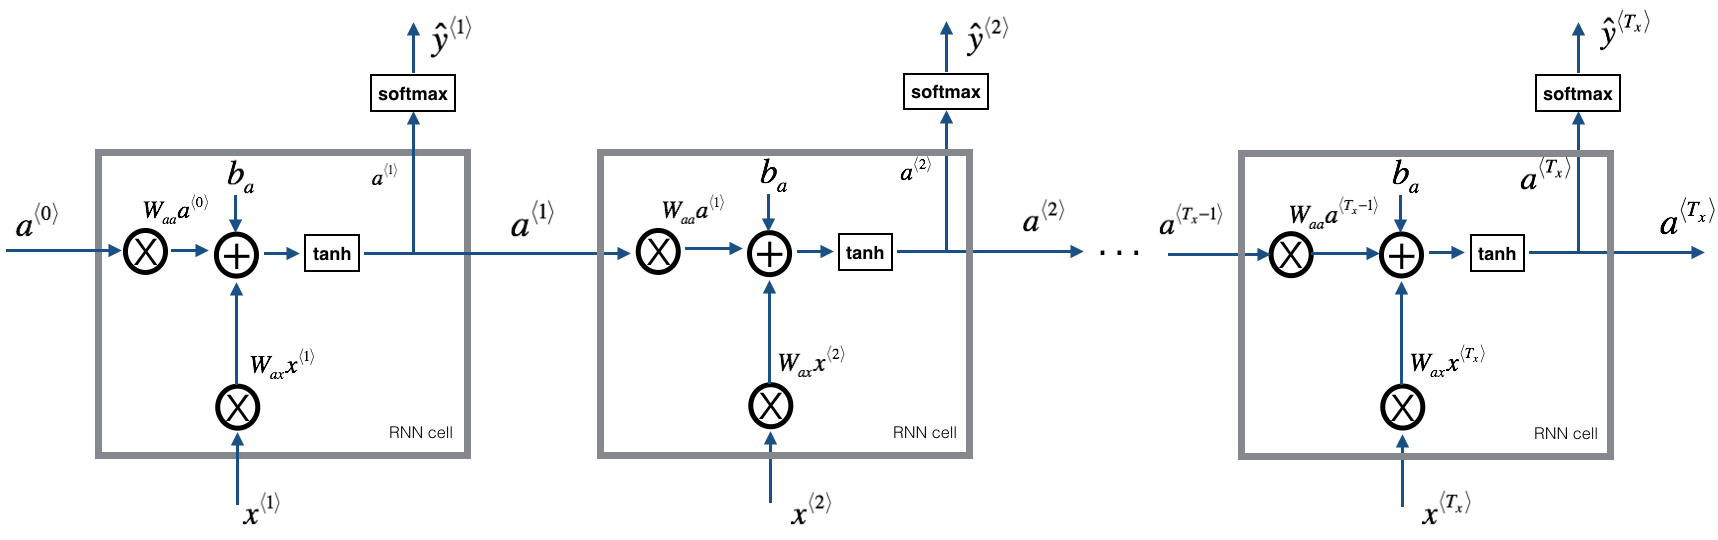

### Tries to predict the next character 

1. X = list of characters from training set
2. Y = output and same characters are input for next block. Y(i) = X(i+1)

### Clipping gradients
   - When gradients explode we clip them to avoid exploding gradients
   - Before updating the parameters we have to perform gradient clipping to make sure your gradients are not clipping.
   
#### Code

   -  

In [77]:
def clip(gradients, MaxValue):

    gradients =  copy.deepcopy(gradients)

    dWaa, dWax, dWya, db, dby = gradients['dWaa'], gradients['dWax'], gradients['dWya'], gradients['db'], gradients['dby']


    for gradient in gradients:
        np.clip(gradients[gradients] , -MaxValue, MaxValue , out = gradients[gradient])

    gradients = {"dWaa": dWaa, "dWax": dWax, "dWya": dWya, "db": db, "dby": dby}

    return gradients

### Sampling

- We do it after training
- we do to test the code, How it is working

#### Code

-  INPUTS - parameters, char-ix , seed( for randomness)

In [108]:
def sample(parameters, char_to_ix , seed):

    Waa, Wax, Wya, by, b = parameters['Waa'], parameters['Wax'], parameters['Wya'], parameters['by'], parameters['b']
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]

    x = np.zeros((vocab_size,1))

    a_prev = np.zeros((n_a,1))

    indices = []

    idx = -1

    counter = 0

    newline_character = char_to_ix['\n']

    while (idx != newline_character and counter !=50):
        a = np.tanh(np.dot(Wax,x) + np.dot(Waa,a_prev) + b)
        z = np.dot(Wya,a) + by
        y = softmax(z)

        np.random.seed(counter + seed)

        idx = np.random.choice(range(len(y)) , p = np.squeeze(y))

        indices.append(idx)

        x = np.zeros((vocab_size , 1))
        x[idx] = 1

        a_prev = a

        seed +=1
        counter +=1

    if (counter == 50):
        indices.append(char_to_ix['\n'])

    return indices



### Optimize

- 

### Model

- Each name is a training example
- Every 2000 steps of stochastic gradient descent we observe fow algo is doing

## Steps

- Initialize parameters
-  

In [109]:
def optimize(X,Y,a_prev, parameters, learning_rate = 0.01):

    loss, cache = rnn_forward(X,Y, a_prev, parameters)

    gradients , a = rnn_backward(X,Y,parameters , cache)

    parameters = update_parameters(parameters, gradients, learning_rate)

    return loss , gradients , a[len(X) - 1]

In [110]:
def  model(data_x , ix_to_char , char_to_ix , num_iterations = 35000 , n_a = 50 , dino_names = 7 , vocab_size = 36, verbose = True ):

    n_x , n_y = vocab_size , vocab_size

    parameters = initialize_parameters(n_a, n_x, n_y)

    loss = get_initial_loss(vocab_size , dino_names)

    examples = [x.strip() for x in data_x]

    np.random.seed(0)
    np.random.shuffle(examples)

    a_prev = np.zeros((n_a,1))
    last_dino_name = "abc"

    for j in range(num_iterations):

        idx = j%len(examples)

        single_ex = None
        single_ex_char = examples[idx]
        single_ex_ix = [char_to_ix[c] for c in single_ex_char]
        X = [None] + single_ex_ix

        Y = X[1:]
        ix_newline = [char_to_ix["\n"]]
        Y = Y + ix_newline

        curr_loss , gradients , a_prev = optimize(X,Y,a_prev , parameters , learning_rate = 0.01)
        

        loss = smooth(loss, curr_loss)
        if j % 2000 == 0:
            
            print('Iteration: %d, Loss: %f' % (j, loss) + '\n')
            
            # The number of dinosaur names to print
            seed = 0
            for name in range(dino_names):
                
                # Sample indices and print them
                sampled_indices = sample(parameters, char_to_ix, seed)
                last_dino_name = get_sample(sampled_indices, ix_to_char)
                print(last_dino_name.replace('\n', ''))
                
                seed += 1  # To get the same result (for grading purposes), increment the seed by one. 
      
            print('\n')


        

    return parameters , last_dino_name



In [112]:
parameters, last_name = model(data.split("\n"), ix_to_char, char_to_ix, 22001, verbose = True)


Iteration: 0, Loss: 25.098968

5f7/zur6d l.78: m3:242mhn1gf02-32rteb.836t3. rza.:
F5.9n
F7/zur6d l.78: m3:242mhn1gf02-32rteb.836t3. rza.:5
5.9n
7/zur6d l.78: m3:242mhn1gf02-32rteb.836t3. rza.:5l
.9n
/zur6d l.78: m3:242mhn1gf02-32rteb.836t3. rza.:5lr


Iteration: 2000, Loss: 87.581311

Siee/h91r1itesish9/f4ogp92gi7icvsite
F/
F7hze91rsitesish9/f4ogp92gi7icvsite
S6.38hg1v91gie
0/6pt4ffitefio/d 46sizn h4esi9294/c
C998oes195psp-df7es47ctiz
Ez1rsi119046p63646coh9c/104f9s.s:tdsb1dvte


Iteration: 4000, Loss: 120.810603

 o0e/hb1.ii
2:.93vh/8991/s/8tseot9098 /99ezo.o8vioe1ctii1
F7e/hb1.ii
 893vh/8991/s/8tseot9098 /99ezo.o8vioe1ctii1
0e/hb1.ii
Cb3vh/8991/s/8tseot9098 /99ezo.o8vioe1ctii1
/ehb1.ii


Iteration: 6000, Loss: 126.485628

 10eehr1dio.08:ie9:21f/g31/f0c-92cceb.891t9.ire:.:
Cud93
27eehr1dio.08:ie9:21f/g31/f0c-92cceb.891t9.ire:.:5
 t93
0eehr1dio.08:ie9:21f/g31/f0c-92cceb.891t9.ire:.:5l
Cvn
/ehr1dio.08:ie9:21f/g31/f0c-92cceb.891t9.ire:.:5lv


Iteration: 8000, Loss: 121.561409

 l7//pb6
F 